<a href="https://colab.research.google.com/github/harman1223-ai/CSCI166/blob/main/Project_166.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

In [ ]:
!AutoROM --accept-license

In [ ]:

import ale_py
import gymnasium as gym

In [ ]:
import gymnasium as gym

env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
obs, info = env.reset()
print("Raw obs shape:", obs.shape, "dtype:", obs.dtype)
print("Action space:", env.action_space)
env.close()


Raw obs shape: (210, 160, 3) dtype: uint8
Action space: Discrete(6)


In [ ]:
import numpy as np
import collections
import typing as tt

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers

# Reorder HWC -> CHW for PyTorch
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        assert isinstance(obs, spaces.Box)
        assert len(obs.shape) == 3
        c = obs.shape[-1]
        h, w = obs.shape[0], obs.shape[1]
        self.observation_space = spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=(c, h, w), dtype=obs.dtype
        )

    def observation(self, observation):
        # (H, W, C) -> (C, H, W)
        return np.moveaxis(observation, 2, 0)

# Simple N-frame stacker
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps: int):
        super().__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        low  = np.repeat(obs.low,  n_steps, axis=0)
        high = np.repeat(obs.high, n_steps, axis=0)
        self.observation_space = spaces.Box(low=low, high=high, dtype=obs.dtype)
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict] = None):
        obs, info = self.env.reset(seed=seed, options=options)
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(obs))
        return self.observation(obs), info

    def observation(self, observation):
        self.buffer.append(observation)
        return np.concatenate(list(self.buffer), axis=0)


def make_env(env_name: str = "ALE/Pong-v5", n_steps: int = 4, render_mode=None):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode)
    # Common Atari preprocessing: grayscale, resize 84x84, frame-skip, etc.
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)         # (C,H,W)
    env = BufferWrapper(env, n_steps) # stack n frames along channel
    return env

# quick test
env = make_env()
obs, info = env.reset()
print("Wrapped obs shape:", obs.shape, "dtype:", obs.dtype)
print("Action space:", env.action_space)
env.close()


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Creating environment ALE/Pong-v5
Wrapped obs shape: (4, 84, 84) dtype: uint8
Action space: Discrete(6)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()

        # input_shape = (C, H, W) = (4, 84, 84)
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # figure out conv output size
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            conv_out_size = self.conv(dummy).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

    def forward(self, x: torch.Tensor):
        # x: (B, C, H, W), uint8 0–255 from env
        x = x.float() / 255.0
        return self.fc(self.conv(x))


# quick sanity check
env = make_env()
obs, info = env.reset()
obs_t = torch.from_numpy(obs).unsqueeze(0).to(device)  # (1,4,84,84)

net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

print(net)
q_values = net(obs_t)
print("Q-values shape:", q_values.shape)  # should be (1, 6)

env.close()

class DuelingDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            conv_out_size = self.conv(dummy).shape[1]

        # Value stream V(s)
        self.value = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

        # Advantage stream A(s,a)
        self.advantage = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

    def forward(self, x: torch.Tensor):
        x = x.float() / 255.0
        f = self.conv(x)
        v = self.value(f)                    # [B, 1]
        a = self.advantage(f)                # [B, A]
        # combine into Q(s,a)
        q = v + (a - a.mean(dim=1, keepdim=True))
        return q

Using device: cuda
Creating environment ALE/Pong-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Q-values shape: torch.Size([1, 6])


using two cells : firstly experience then replay then agent and then loss.

Secondly Hyperparameters and plus training loop


In [ ]:
from dataclasses import dataclass
import time
import collections
import typing as tt
import numpy as np

# ----- Types -----
State  = np.ndarray
Action = int

@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done: bool
    next_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, exp: Experience):
        self.buffer.append(exp)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in idxs]


class Agent:
    def __init__(self, env, buffer: ExperienceBuffer):
        self.env = env
        self.buffer = buffer
        self.state: State | None = None
        self.total_reward = 0.0
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device, epsilon: float = 0.0) -> float | None:
        done_reward = None

        # epsilon-greedy
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            s_v = torch.as_tensor(self.state, device=device).unsqueeze(0)  # (1,4,84,84)
            q_vals = net(s_v)
            action = int(q_vals.argmax(dim=1).item())

        # gymnasium step
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        self.total_reward += reward

        exp = Experience(
            state=self.state,
            action=action,
            reward=float(reward),
            done=done,
            next_state=next_state,
        )
        self.buffer.append(exp)
        self.state = next_state

        if done:
            done_reward = self.total_reward
            self._reset()

        return done_reward


def batch_to_tensors(batch: tt.List[Experience], device: torch.device):
    states      = np.stack([e.state      for e in batch])
    actions     = np.array([e.action     for e in batch], dtype=np.int64)
    rewards     = np.array([e.reward     for e in batch], dtype=np.float32)
    dones       = np.array([e.done       for e in batch], dtype=np.bool_)
    next_states = np.stack([e.next_state for e in batch])

    states_t      = torch.as_tensor(states,      device=device)  # uint8
    actions_t     = torch.as_tensor(actions,     device=device)
    rewards_t     = torch.as_tensor(rewards,     device=device)
    dones_t       = torch.as_tensor(dones,       device=device)
    next_states_t = torch.as_tensor(next_states, device=device)

    return states_t, actions_t, rewards_t, dones_t, next_states_t


# baseline 1-step DQN loss (we'll upgrade to Double DQN later)
GAMMA = 0.99

def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN, device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, next_states_t = batch_to_tensors(batch, device)

    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        next_q = tgt_net(next_states_t).max(dim=1)[0]
        next_q[dones_t] = 0.0
        target = rewards_t + GAMMA * next_q

    return nn.MSELoss()(q_sa, target)



In [ ]:
# ---- Hyperparams ----
BATCH_SIZE          = 32
REPLAY_SIZE         = 50_000
REPLAY_START_SIZE   = 10_000
LEARNING_RATE       = 1e-4
SYNC_TARGET_FRAMES  = 1_000
EPSILON_START       = 1.0
EPSILON_FINAL       = 0.02
EPSILON_DECAY_FRAMES = 200_000   # faster decay for Colab tests

MEAN_REWARD_BOUND   = 10  # stop when agent averages this over last 100 eps

# ---- Init env, nets, buffer, agent, optimizer ----
env = make_env()
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net.load_state_dict(net.state_dict())

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

total_rewards: list[float] = []
best_m_reward = None
frame_idx = 0
epsilon = EPSILON_START

print("Starting training...")

while True:
    frame_idx += 1
    # linear epsilon decay
    epsilon = max(
        EPSILON_FINAL,
        EPSILON_START - frame_idx / EPSILON_DECAY_FRAMES
    )

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        m_reward = np.mean(total_rewards[-100:])
        print(f"{frame_idx}: episodes={len(total_rewards)}, "
              f"reward={reward:.1f}, mean_100={m_reward:.2f}, eps={epsilon:.3f}")

        if best_m_reward is None or m_reward > best_m_reward:
            best_m_reward = m_reward

        if m_reward >= MEAN_REWARD_BOUND and len(total_rewards) >= 100:
            print(f"Solved with mean reward {m_reward:.2f} in {frame_idx} frames")
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue

    # sync target net
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    # one gradient step
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()


Creating environment ALE/Pong-v5
Starting training...
209: episodes=1, reward=-20.0, mean_100=-20.00, eps=0.999
460: episodes=2, reward=-19.0, mean_100=-19.50, eps=0.998
676: episodes=3, reward=-20.0, mean_100=-19.67, eps=0.997
880: episodes=4, reward=-21.0, mean_100=-20.00, eps=0.996
1163: episodes=5, reward=-19.0, mean_100=-19.80, eps=0.994
1425: episodes=6, reward=-21.0, mean_100=-20.00, eps=0.993
1671: episodes=7, reward=-20.0, mean_100=-20.00, eps=0.992
1872: episodes=8, reward=-21.0, mean_100=-20.12, eps=0.991
2061: episodes=9, reward=-21.0, mean_100=-20.22, eps=0.990
2295: episodes=10, reward=-21.0, mean_100=-20.30, eps=0.989
2508: episodes=11, reward=-21.0, mean_100=-20.36, eps=0.987
2724: episodes=12, reward=-21.0, mean_100=-20.42, eps=0.986
2920: episodes=13, reward=-21.0, mean_100=-20.46, eps=0.985
3139: episodes=14, reward=-21.0, mean_100=-20.50, eps=0.984
3328: episodes=15, reward=-21.0, mean_100=-20.53, eps=0.983
3548: episodes=16, reward=-21.0, mean_100=-20.56, eps=0.982

KeyboardInterrupt: 

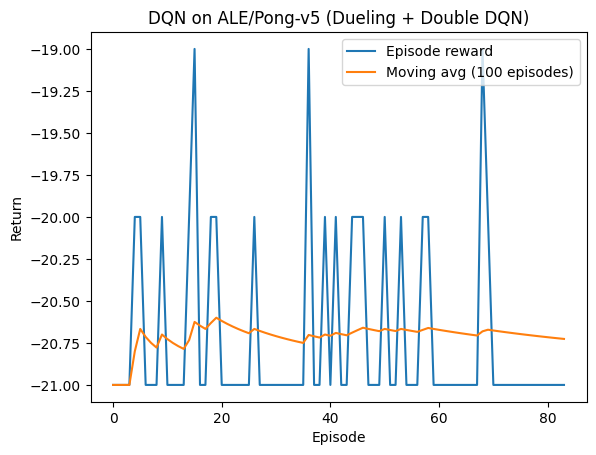

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rewards = np.array(total_rewards)
moving_avg = np.array([rewards[max(0, i-99):i+1].mean() for i in range(len(rewards))])

plt.figure()
plt.plot(rewards, label="Episode reward")
plt.plot(moving_avg, label="Moving avg (100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.title("DQN on ALE/Pong-v5 (Dueling + Double DQN)")
plt.show()


Reward is around -21 and -18 thats basically the random/early stage of Pong. Loop is behaving as expected. Right now its in the "loses every game' phase which is normal. Training is slow, next step replace calc_loss with Double DQN version so get rid of with torch.no_grad():

In [ ]:
# ===========================
# BASELINE DQN ON ALE/Pong-v5
# ===========================
import os
import time
import collections
from dataclasses import dataclass
import typing as tt

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import ale_py
from gymnasium import spaces
from stable_baselines3.common import atari_wrappers

import torch
import torch.nn as nn
import torch.optim as optim

# ---------------------------
# Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# ENV WRAPPERS
# ---------------------------
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Reorder (H, W, C) -> (C, H, W)
    """
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        assert isinstance(obs, spaces.Box)
        assert len(obs.shape) == 3
        c = obs.shape[-1]
        h = obs.shape[0]
        w = obs.shape[1]
        new_shape = (c, h, w)
        self.observation_space = spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype
        )

    def observation(self, observation):
        # (H, W, C) -> (C, H, W)
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    Stack last n_steps frames along channel dimension.
    """
    def __init__(self, env, n_steps: int):
        super().__init__(env)
        self.n_steps = n_steps
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        low = np.repeat(obs.low, n_steps, axis=0)
        high = np.repeat(obs.high, n_steps, axis=0)
        self.observation_space = spaces.Box(low=low, high=high, dtype=obs.dtype)
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict] = None):
        obs, info = self.env.reset(seed=seed, options=options)
        self.buffer.clear()
        for _ in range(self.n_steps):
            self.buffer.append(np.zeros_like(obs, dtype=obs.dtype))
        self.buffer.append(obs)
        return self._get_obs(), info

    def observation(self, observation):
        self.buffer.append(observation)
        return self._get_obs()

    def _get_obs(self):
        return np.concatenate(list(self.buffer), axis=0)


def make_env(env_name="ALE/Pong-v5", n_frames=4):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode="rgb_array")
    # Stable-baselines Atari wrapper: warp, grayscale, frame skipping, etc.
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_frames)
    obs, info = env.reset()
    print("Wrapped obs shape:", obs.shape, "dtype:", obs.dtype)
    print("Action space:", env.action_space)
    return env


# ---------------------------
# DQN MODEL
# ---------------------------
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            conv_out = self.conv(dummy).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_out, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

    def forward(self, x: torch.Tensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))


# ---------------------------
# EXPERIENCE / BUFFER
# ---------------------------
State = np.ndarray
Action = int

@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool   # terminated or truncated
    next_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, exp: Experience):
        self.buffer.append(exp)

    def sample(self, batch_size: int) -> list[Experience]:
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in idxs]


# ---------------------------
# AGENT
# ---------------------------
class Agent:
    def __init__(self, env: gym.Env, buffer: ExperienceBuffer):
        self.env = env
        self.buffer = buffer
        self.state: tt.Optional[np.ndarray] = None
        self.total_reward = 0.0
        self.reset()

    def reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device, epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state, device=device).unsqueeze(0)  # (1,C,H,W)
            q_values = net(state_v)
            action = int(q_values.argmax(dim=1).item())

        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward

        exp = Experience(
            state=self.state,
            action=action,
            reward=float(reward),
            done_trunc=done,
            next_state=next_state,
        )
        self.buffer.append(exp)

        self.state = next_state

        if done:
            done_reward = self.total_reward
            self.reset()

        return done_reward


# ---------------------------
# BATCH TO TENSORS
# ---------------------------
def batch_to_tensors(batch: list[Experience], device: torch.device):
    states = np.stack([e.state for e in batch])
    actions = np.array([e.action for e in batch], dtype=np.int64)
    rewards = np.array([e.reward for e in batch], dtype=np.float32)
    dones = np.array([e.done_trunc for e in batch], dtype=np.bool_)
    next_states = np.stack([e.next_state for e in batch])

    states_t = torch.as_tensor(states, device=device)          # uint8
    actions_t = torch.as_tensor(actions, device=device)
    rewards_t = torch.as_tensor(rewards, device=device)
    dones_t = torch.as_tensor(dones, device=device)
    next_states_t = torch.as_tensor(next_states, device=device)

    return states_t, actions_t, rewards_t, dones_t, next_states_t


# ---------------------------
# BASELINE DQN LOSS
# ---------------------------
GAMMA = 0.99

def calc_loss(batch: list[Experience], net: DQN, tgt_net: DQN, device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, next_states_t = batch_to_tensors(batch, device)

    # Q(s, a) from online net
    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    # Baseline DQN target: max over target net
    with torch.no_grad():
        next_q = tgt_net(next_states_t).max(dim=1)[0]
        next_q[dones_t] = 0.0
        target = rewards_t + GAMMA * next_q

    return nn.MSELoss()(q_sa, target)


# ---------------------------
# HYPERPARAMS
# ---------------------------
ENV_NAME = "ALE/Pong-v5"

REPLAY_SIZE = 50_000
REPLAY_START_SIZE = 10_000
BATCH_SIZE = 32

SYNC_TARGET_FRAMES = 1_000
LEARNING_RATE = 1e-4

EPS_START = 1.0
EPS_FINAL = 0.02
EPS_DECAY_LAST_FRAME = 300_000  # how fast epsilon goes down

MAX_FRAMES = 400_000  # cut early for Colab sanity


# ---------------------------
# CREATE ENV, NETS, AGENT
# ---------------------------
env = make_env(ENV_NAME, n_frames=4)
obs_shape = env.observation_space.shape
n_actions = env.action_space.n

net = DQN(obs_shape, n_actions).to(device)
tgt_net = DQN(obs_shape, n_actions).to(device)
tgt_net.load_state_dict(net.state_dict())

print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# ---------------------------
# TRAINING LOOP
# ---------------------------
episode_rewards: list[float] = []
moving_avg_100: list[float] = []

epsilon = EPS_START
frame_idx = 0
best_mean_reward = None

print("Starting baseline DQN training...")

for frame_idx in range(1, MAX_FRAMES + 1):
    epsilon = max(EPS_FINAL, EPS_START - frame_idx / EPS_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        episode_rewards.append(reward)
        mean_100 = np.mean(episode_rewards[-100:])
        moving_avg_100.append(mean_100)
        print(f"{frame_idx}: episodes={len(episode_rewards)}, reward={reward}, mean_100={mean_100:.2f}, eps={epsilon:.3f}")

    if len(buffer) < REPLAY_START_SIZE:
        continue

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

env.close()

print("Training finished. Episodes:", len(episode_rewards))

# ---------------------------
# PLOT LEARNING CURVE
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(episode_rewards, label="Episode reward")
if len(moving_avg_100) > 0:
    plt.plot(moving_avg_100, label="Moving avg (100 episodes)")
plt.title("Baseline DQN on ALE/Pong-v5")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using device: cuda
Creating environment ALE/Pong-v5
Wrapped obs shape: (4, 84, 84) dtype: uint8
Action space: Discrete(6)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Starting baseline DQN training...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


263: episodes=1, reward=-21.0, mean_100=-21.00, eps=0.999
481: episodes=2, reward=-20.0, mean_100=-20.50, eps=0.998
713: episodes=3, reward=-21.0, mean_100=-20.67, eps=0.998
918: episodes=4, reward=-21.0, mean_100=-20.75, eps=0.997
1107: episodes=5, reward=-21.0, mean_100=-20.80, eps=0.996
1311: episodes=6, reward=-21.0, mean_100=-20.83, eps=0.996
1500: episodes=7, reward=-21.0, mean_100=-20.86, eps=0.995
1723: episodes=8, reward=-20.0, mean_100=-20.75, eps=0.994
1957: episodes=9, reward=-21.0, mean_100=-20.78, eps=0.993
2220: episodes=10, reward=-21.0, mean_100=-20.80, eps=0.993
2440: episodes=11, reward=-21.0, mean_100=-20.82, eps=0.992
2629: episodes=12, reward=-21.0, mean_100=-20.83, eps=0.991
2838: episodes=13, reward=-21.0, mean_100=-20.85, eps=0.991
3042: episodes=14, reward=-21.0, mean_100=-20.86, eps=0.990
3231: episodes=15, reward=-21.0, mean_100=-20.87, eps=0.989
3470: episodes=16, reward=-21.0, mean_100=-20.88, eps=0.988
3705: episodes=17, reward=-21.0, mean_100=-20.88, eps

KeyboardInterrupt: 

In [ ]:
# ==========================
# Pong video recording cell
# ==========================
import imageio.v2 as imageio
from pathlib import Path

# Make sure these still exist in the notebook
try:
    ENV_NAME
except NameError:
    ENV_NAME = "ALE/Pong-v5"

try:
    device
except NameError:
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reuse the SAME wrappers as training, but with render_mode="rgb_array"
def make_video_env(env_name="ALE/Pong-v5", n_frames=4):
    env = gym.make(env_name, render_mode="rgb_array")
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_frames)
    return env

@torch.no_grad()
def run_episode_for_video(env, filename, policy_net=None, epsilon: float = 0.0, max_steps: int = 10_000):
    """
    Run ONE episode and save it as MP4.
    - policy_net=None  -> pure random.
    - otherwise uses greedy policy from policy_net (with optional epsilon).
    """
    frames = []
    obs, info = env.reset()

    for t in range(max_steps):
        # get RGB frame from env
        frame = env.render()
        frames.append(frame)

        if (policy_net is None) or (np.random.rand() < epsilon):
            action = env.action_space.sample()
        else:
            s_v = torch.as_tensor(obs, device=device).unsqueeze(0)
            q_vals = policy_net(s_v)
            action = int(q_vals.argmax(dim=1).item())

        obs, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

    imageio.mimsave(filename, frames, fps=30)
    print(f"Saved {filename} with {len(frames)} frames")
    return filename

# -----------------------------
# 1) RANDOM POLICY VIDEO
# -----------------------------
print("Recording RANDOM policy video...")
env_random = make_video_env(ENV_NAME, n_frames=4)
rand_path = "pong_random_baseline.mp4"
run_episode_for_video(env_random, rand_path, policy_net=None)
env_random.close()

# -----------------------------
# 2) TRAINED BASELINE DQN VIDEO
# -----------------------------
print("Recording TRAINED baseline DQN video...")
net.eval()   # eval mode for recording
env_trained = make_video_env(ENV_NAME, n_frames=4)
trained_path = "pong_trained_baseline.mp4"
run_episode_for_video(env_trained, trained_path, policy_net=net, epsilon=0.0)
env_trained.close()
net.train()

print("Videos saved in working directory:")
print(" -", rand_path)
print(" -", trained_path)


Recording RANDOM policy video...


Saved pong_random_baseline.mp4 with 231 frames
Recording TRAINED baseline DQN video...


Saved pong_trained_baseline.mp4 with 369 frames
Videos saved in working directory:
 - pong_random_baseline.mp4
 - pong_trained_baseline.mp4


Episodes logged: 118


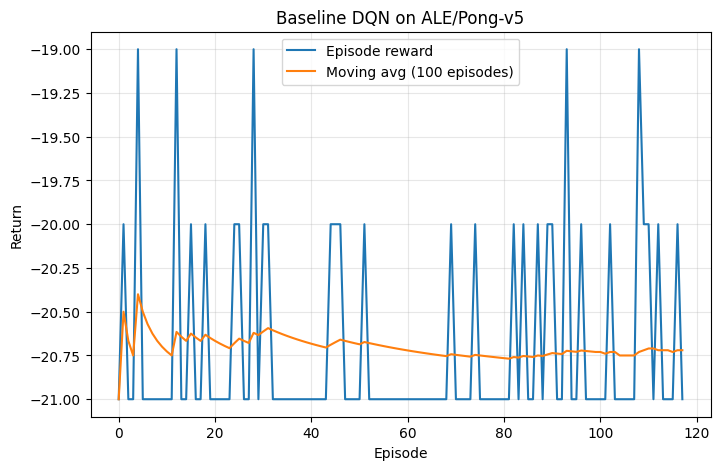

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Safety checks
print("Episodes logged:", len(episode_rewards))

# If you already have moving_avg_100 from the loop, use it.
# If not, recompute it here:
if "moving_avg_100" not in globals() or len(moving_avg_100) != len(episode_rewards):
    window = 100
    moving_avg_100 = []
    for i in range(len(episode_rewards)):
        start = max(0, i - window + 1)
        moving_avg_100.append(np.mean(episode_rewards[start:i+1]))

plt.figure(figsize=(8, 5))
plt.plot(episode_rewards, label="Episode reward")
plt.plot(moving_avg_100, label="Moving avg (100 episodes)")
plt.title("Baseline DQN on ALE/Pong-v5")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# ============================
# VIDEO RECORDING SECTION
# ============================

import os
from gymnasium.wrappers import RecordVideo

# If not defined earlier, define here:
try:
    ENV_NAME
except NameError:
    ENV_NAME = "ALE/Pong-v5"

VIDEO_DIR = "videos"
os.makedirs(VIDEO_DIR, exist_ok=True)

def make_video_env(env_name, n_frames=4, prefix="pong"):
    base_env = gym.make(env_name, render_mode="rgb_array")
    base_env = atari_wrappers.AtariWrapper(base_env, clip_reward=False, noop_max=0)
    base_env = ImageToPyTorch(base_env)
    base_env = BufferWrapper(base_env, n_steps=n_frames)

    return RecordVideo(
        base_env,
        video_folder=VIDEO_DIR,
        name_prefix=prefix,
        episode_trigger=lambda x: True,
        disable_logger=True,
    )

@torch.no_grad()
def run_episode_for_video(env, policy_net=None, epsilon=0.0):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        if policy_net is None or np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = int(policy_net(s).argmax(dim=1).item())

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    return total_reward

print("\n--- RECORDING RANDOM POLICY VIDEO ---")
env_rand = make_video_env(ENV_NAME, prefix="pong_random")
r0 = run_episode_for_video(env_rand, policy_net=None)
env_rand.close()
print("Random episode return:", r0)

print("\n--- RECORDING TRAINED POLICY VIDEO ---")
env_train = make_video_env(ENV_NAME, prefix="pong_trained")
r1 = run_episode_for_video(env_train, policy_net=net, epsilon=0.0)
env_train.close()
print("Trained episode return:", r1)

print("\nSaved videos inside /videos:")
print(os.listdir("videos"))


In [ ]:
"""
variant_dqn.py
CSCI 166 – Pong DQN Variant
Dueling DQN + Double DQN target on ALE/Pong-v5
"""

import os
import collections
from dataclasses import dataclass
import typing as tt

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import ale_py
from gymnasium import spaces
from stable_baselines3.common import atari_wrappers

import torch
import torch.nn as nn
import torch.optim as optim


# ---------------------------
# Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ---------------------------
# ENV WRAPPERS
# ---------------------------
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Reorder (H, W, C) -> (C, H, W) for PyTorch.
    """
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        assert isinstance(obs, spaces.Box)
        assert len(obs.shape) == 3
        c = obs.shape[-1]
        h = obs.shape[0]
        w = obs.shape[1]
        new_shape = (c, h, w)
        self.observation_space = spaces.Box(
            low=obs.low.min(),
            high=obs.high.max(),
            shape=new_shape,
            dtype=obs.dtype,
        )

    def observation(self, observation):
        # (H, W, C) -> (C, H, W)
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    Stack the last n_steps frames along the channel dimension.
    """
    def __init__(self, env, n_steps: int):
        super().__init__(env)
        self.n_steps = n_steps
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        low = np.repeat(obs.low, n_steps, axis=0)
        high = np.repeat(obs.high, n_steps, axis=0)
        self.observation_space = spaces.Box(low=low, high=high, dtype=obs.dtype)
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict] = None):
        obs, info = self.env.reset(seed=seed, options=options)
        self.buffer.clear()
        for _ in range(self.n_steps):
            self.buffer.append(np.zeros_like(obs, dtype=obs.dtype))
        self.buffer.append(obs)
        return self._get_obs(), info

    def observation(self, observation):
        self.buffer.append(observation)
        return self._get_obs()

    def _get_obs(self):
        return np.concatenate(list(self.buffer), axis=0)


def make_env(env_name: str = "ALE/Pong-v5", n_frames: int = 4) -> gym.Env:
    """
    Create Pong env with Atari preprocessing and 4-frame stack.
    """
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode="rgb_array")
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_frames)

    obs, info = env.reset()
    print("Wrapped obs shape:", obs.shape, "dtype:", obs.dtype)
    print("Action space:", env.action_space)
    return env


# ---------------------------
# Dueling DQN MODEL
# ---------------------------
class DuelingDQN(nn.Module):
    """
    Dueling DQN:
      shared conv trunk
      separate Value and Advantage streams
      Q(s,a) = V(s) + (A(s,a) - mean_a A(s,a))
    """
    def __init__(self, input_shape, n_actions):
        super().__init__()

        # Shared conv trunk
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            conv_out = self.conv(dummy).shape[1]

        # Value stream V(s)
        self.value = nn.Sequential(
            nn.Linear(conv_out, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

        # Advantage stream A(s,a)
        self.advantage = nn.Sequential(
            nn.Linear(conv_out, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

    def forward(self, x: torch.Tensor):
        x = x.float() / 255.0
        feats = self.conv(x)
        v = self.value(feats)                    # [B, 1]
        a = self.advantage(feats)                # [B, A]
        q = v + (a - a.mean(dim=1, keepdim=True))
        return q


# ---------------------------
# EXPERIENCE / BUFFER
# ---------------------------
State = np.ndarray
Action = int

@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool   # terminated or truncated
    next_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, exp: Experience):
        self.buffer.append(exp)

    def sample(self, batch_size: int) -> list[Experience]:
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in idxs]


# ---------------------------
# AGENT
# ---------------------------
class Agent:
    def __init__(self, env: gym.Env, buffer: ExperienceBuffer):
        self.env = env
        self.buffer = buffer
        self.state: tt.Optional[np.ndarray] = None
        self.total_reward = 0.0
        self.reset()

    def reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: nn.Module, device: torch.device, epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        # epsilon-greedy
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state, device=device).unsqueeze(0)  # (1,C,H,W)
            q_values = net(state_v)
            action = int(q_values.argmax(dim=1).item())

        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward

        exp = Experience(
            state=self.state,
            action=action,
            reward=float(reward),
            done_trunc=done,
            next_state=next_state,
        )
        self.buffer.append(exp)

        self.state = next_state

        if done:
            done_reward = self.total_reward
            self.reset()

        return done_reward


# ---------------------------
# BATCH TO TENSORS
# ---------------------------
def batch_to_tensors(batch: list[Experience], device: torch.device):
    states      = np.stack([e.state      for e in batch])
    actions     = np.array([e.action     for e in batch], dtype=np.int64)
    rewards     = np.array([e.reward     for e in batch], dtype=np.float32)
    dones       = np.array([e.done_trunc for e in batch], dtype=np.bool_)
    next_states = np.stack([e.next_state for e in batch])

    states_t      = torch.as_tensor(states,      device=device)  # uint8
    actions_t     = torch.as_tensor(actions,     device=device)
    rewards_t     = torch.as_tensor(rewards,     device=device)
    dones_t       = torch.as_tensor(dones,       device=device)
    next_states_t = torch.as_tensor(next_states, device=device)

    return states_t, actions_t, rewards_t, dones_t, next_states_t


# ---------------------------
# DOUBLE DQN LOSS (with Dueling net)
# ---------------------------
GAMMA = 0.99

def calc_loss_double_dqn(
    batch: list[Experience],
    net: nn.Module,
    tgt_net: nn.Module,
    device: torch.device,
) -> torch.Tensor:
    """
    Double DQN target:
      a* = argmax_a Q_online(s', a)
      target = r + γ Q_target(s', a*)
    """
    states_t, actions_t, rewards_t, dones_t, next_states_t = batch_to_tensors(batch, device)

    # Q(s,a) from online net
    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        # Online net chooses greedy action at next state
        next_q_online = net(next_states_t)
        next_actions  = next_q_online.argmax(dim=1)           # [B]

        # Target net evaluates that action
        next_q_target = tgt_net(next_states_t).gather(
            1, next_actions.unsqueeze(-1)
        ).squeeze(-1)                                         # [B]

        next_q_target[dones_t] = 0.0
        target = rewards_t + GAMMA * next_q_target

    loss = nn.SmoothL1Loss()(q_sa, target)  # Huber loss
    return loss


# ---------------------------
# HYPERPARAMS
# ---------------------------
ENV_NAME = "ALE/Pong-v5"

REPLAY_SIZE        = 50_000
REPLAY_START_SIZE  = 10_000
BATCH_SIZE         = 32

SYNC_TARGET_FRAMES = 1_000
LEARNING_RATE      = 1e-4

EPS_START          = 1.0
EPS_FINAL          = 0.02
EPS_DECAY_FRAMES   = 200_000   # slower decay for better exploration

MAX_FRAMES         = 400_000   # safety cap


# ---------------------------
# MAIN TRAINING
# ---------------------------
def main():
    env = make_env(ENV_NAME, n_frames=4)
    obs_shape = env.observation_space.shape
    n_actions = env.action_space.n

    # Dueling network as online + target
    net     = DuelingDQN(obs_shape, n_actions).to(device)
    tgt_net = DuelingDQN(obs_shape, n_actions).to(device)
    tgt_net.load_state_dict(net.state_dict())

    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent  = Agent(env, buffer)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    episode_rewards: list[float] = []
    moving_avg_100: list[float] = []

    epsilon = EPS_START

    print("Starting Dueling + Double DQN training...")

    for frame_idx in range(1, MAX_FRAMES + 1):
        epsilon = max(EPS_FINAL, EPS_START - frame_idx / EPS_DECAY_FRAMES)

        reward = agent.play_step(net, device, epsilon)
        if reward is not None:
            episode_rewards.append(reward)
            mean_100 = np.mean(episode_rewards[-100:])
            moving_avg_100.append(mean_100)
            print(
                f"{frame_idx}: episodes={len(episode_rewards)}, "
                f"reward={reward:.1f}, mean_100={mean_100:.2f}, eps={epsilon:.3f}"
            )

        if len(buffer) < REPLAY_START_SIZE:
            continue

        # One gradient step
        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss_double_dqn(batch, net, tgt_net, device)
        loss_t.backward()
        optimizer.step()

        # Sync target net
        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

    env.close()
    print("Training finished. Episodes:", len(episode_rewards))

    # ----- Plot learning curve -----
    plt.figure(figsize=(8, 5))
    plt.plot(episode_rewards, label="Episode reward")
    if len(moving_avg_100) > 0:
        plt.plot(moving_avg_100, label="Moving avg (100 episodes)")
    plt.title("DQN on ALE/Pong-v5 (Dueling + Double DQN)")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True, alpha=0.3)

    out_name = "variant_dqn + double.png"
    plt.savefig(out_name, bbox_inches="tight")
    print(f"Saved learning curve to {out_name}")
    plt.show()


if __name__ == "__main__":
    main()


Using device: cuda
Creating environment ALE/Pong-v5
Wrapped obs shape: (4, 84, 84) dtype: uint8
Action space: Discrete(6)
DuelingDQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (value): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (advantage): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Starting Dueling + Double DQN training...
206: episodes=1, reward=-21.0, mean_100=-21.00, eps=0.999
445: episodes=2, reward=-20.0, mean_100=-20.50, eps=0.998
654: episodes=3, reward=-21.0, mean_100=-20.67, eps=0.997
863: episodes=4, rew

KeyboardInterrupt: 

Episodes logged: 219


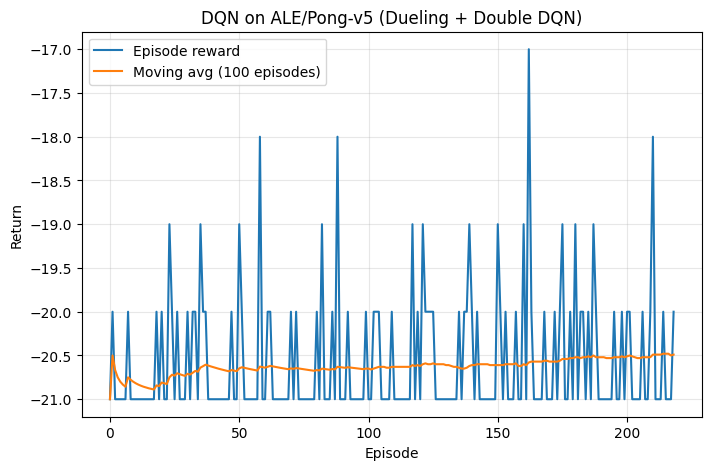

Saved learning curve to variant dqn + double.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# If you used different variable names, adjust these:
# e.g. episode_rewards_variant -> episode_rewards
print("Episodes logged:", len(episode_rewards))

rewards = np.array(episode_rewards)

# 100-episode moving average
moving_avg_100 = []
window = 100
for i in range(len(rewards)):
    start = max(0, i - window + 1)
    moving_avg_100.append(rewards[start:i+1].mean())
moving_avg_100 = np.array(moving_avg_100)

plt.figure(figsize=(8, 5))
plt.plot(rewards, label="Episode reward")
plt.plot(moving_avg_100, label="Moving avg (100 episodes)")
plt.title("DQN on ALE/Pong-v5 (Dueling + Double DQN)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid(True, alpha=0.3)

# this is the file you need for the project
plt.savefig("variant dqn + double.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved learning curve to variant dqn + double.png")
